In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.distributions import Normal


class PPO(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.9, batch_size=128, 
                 epsilon=0.2, epoch_n=30, pi_lr=1e-4, v_lr=5e-4):

        super().__init__()
        
        self.pi_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                      nn.Linear(128, 128), nn.ReLU(),
                                      nn.Linear(128, 2 * action_dim), nn.Tanh())
        
        self.v_model = nn.Sequential(nn.Linear(state_dim, 128), nn.ReLU(),
                                     nn.Linear(128, 128), nn.ReLU(),
                                     nn.Linear(128, 1))
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch_n = epoch_n
        self.pi_optimizer = torch.optim.Adam(self.pi_model.parameters(), lr=pi_lr)
        self.v_optimizer = torch.optim.Adam(self.v_model.parameters(), lr=v_lr)

    def get_action(self, state):
        mean, log_std = self.pi_model(torch.FloatTensor(state))
        dist = Normal(mean, torch.exp(log_std))
        action = dist.sample()
        return action.numpy().reshape(1)

    def fit(self, states, actions, rewards, dones):
        mean_pi_losses = []
        mean_v_losses = []
        
        states, actions, rewards, dones = map(np.array, [states, actions, rewards, dones])
        rewards, dones = rewards.reshape(-1, 1), dones.reshape(-1, 1)

        returns = np.zeros(rewards.shape)
        returns[-1] = rewards[-1]
        for t in range(returns.shape[0] - 2, -1, -1):
            returns[t] = rewards[t] + (1 - dones[t]) * self.gamma * returns[t + 1]

        states, actions, returns = map(torch.FloatTensor, [states, actions, returns])

        mean, log_std = self.pi_model(states).T
        mean, log_std = mean.unsqueeze(1), log_std.unsqueeze(1)
        dist = Normal(mean, torch.exp(log_std))
        old_log_probs = dist.log_prob(actions).detach()

        for epoch in range(self.epoch_n):
            pi_losses = []
            v_losses = []
            
            idxs = np.random.permutation(returns.shape[0])
            for i in range(0, returns.shape[0], self.batch_size):
                b_idxs = idxs[i: i + self.batch_size]
                b_states = states[b_idxs]
                b_actions = actions[b_idxs]
                b_returns = returns[b_idxs]
                b_old_log_probs = old_log_probs[b_idxs]
    
                b_advantage = b_returns.detach() - self.v_model(b_states)
                
                b_mean, b_log_std = self.pi_model(b_states).T
                b_mean, b_log_std = b_mean.unsqueeze(1), b_log_std.unsqueeze(1)
                b_dist = Normal(b_mean, torch.exp(b_log_std))
                b_new_log_probs = b_dist.log_prob(b_actions)
    
                b_ratio = torch.exp(b_new_log_probs - b_old_log_probs)
                pi_loss_1 = b_ratio * b_advantage.detach()
                pi_loss_2 = torch.clamp(b_ratio, 1. - self.epsilon,  1. + self.epsilon) * b_advantage.detach()
                pi_loss = - torch.mean(torch.min(pi_loss_1, pi_loss_2))
                pi_losses.append(pi_loss.data.numpy())
                
                pi_loss.backward()
                self.pi_optimizer.step()
                self.pi_optimizer.zero_grad()
                
                v_loss = torch.mean(b_advantage ** 2)
                v_losses.append(v_loss.data.numpy())
    
                v_loss.backward()
                self.v_optimizer.step()
                self.v_optimizer.zero_grad()

            mean_pi_losses.append(np.mean(pi_losses))
            mean_v_losses.append(np.mean(v_losses))
        return mean_pi_losses, mean_v_losses

/home/iukash/development/python/gym/gym_env/lib/python3.10/site-packages/gym/utils/env_checker.py:200: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


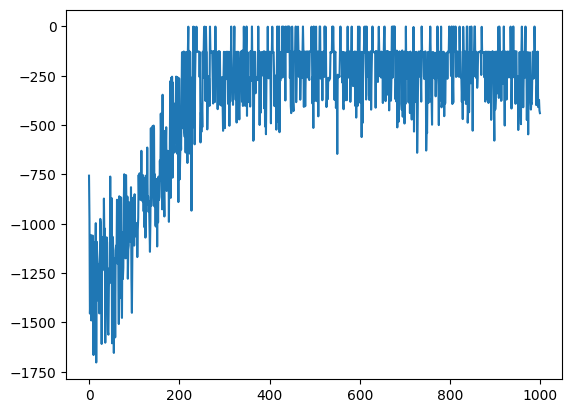

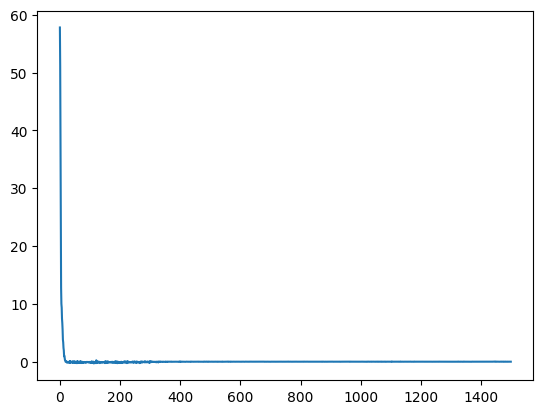

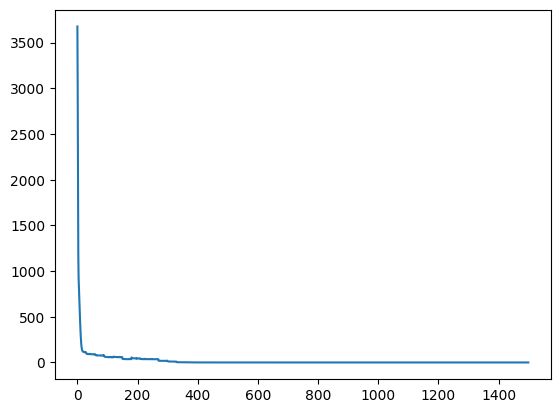

In [2]:
env = gym.make('Pendulum-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = PPO(state_dim, action_dim)

episode_n = 50
trajectory_n = 20

total_rewards = []
mean_pi_losses, mean_v_losses = [], []
for episode in range(episode_n):

    states, actions, rewards, dones = [], [], [], []

    for _ in range(trajectory_n):
        total_reward = 0

        state = env.reset()
        for t in range(200):
            states.append(state)
            
            action = agent.get_action(state)
            actions.append(action)
            
            state, reward, done, _ = env.step(2 * action)
            rewards.append(reward)
            dones.append(done)

            total_reward += reward

        total_rewards.append(total_reward)

    _mean_pi_losses, _mean_v_losses = agent.fit(states, actions, rewards, dones)
    mean_pi_losses.extend(_mean_pi_losses)
    mean_v_losses.extend(_mean_v_losses)

plt.plot(total_rewards)
plt.show()
plt.plot(mean_pi_losses)
plt.show()
plt.plot(mean_v_losses)
plt.show()